<a href="https://colab.research.google.com/github/Aidin-Poorsolhjouy/DT2/blob/main/DT2_Project_Milling_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tips
- synthetic dataset, so maybe perturb some data points artificially to mimic real-world noise
- imbalanced dataset, so oversampling maybe (SMOTE, SVMSMOTE, RandomOverSampler)


#My Process
- first just binary classification
- remove the index and serial number columns
- check for distributions, outlier, etc of the numeric cols
- check correlation of variables with each other (temperatures are related! maybe create new feature by subtracting them! torque and rotational speed are correlated so we don't drop one. because different natures and information!)
- from DT class: you can combine models (classifiers) for performing together, like a voting system, to improve the performance of your model
- Tqdm library to show progress bars for loops and iterables
- Hyperparameter tuning: The remedy is to use three separate datasets: a training set for training, a validation set for hyperparameter tuning, and a test set for estimating the final performance. Or, use nested cross validation, which will give better estimates, and is necessary if there isn't enough data.
- oversampling vs not / hyperparameter tuning / feature engineering

-24 records contain more than one type of failure



- find the best model for each failure mode (LGBMClassifier for one of the failure modes)
- XGBoost and CatBoost and outputcodeclassifier

##Some keywords:
- multiclass classification vs multilabel (part of multioutput) classification
- stratified k fold
- columntransformers
- balanced accuracy, matthews correlation coefficient

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
#from lightgbm import LGBMClassifier

In [ ]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [ ]:
df.rename(columns={'Air temperature [K]': 'Air temperature K', 'Process temperature [K]': 'Process temperature K'
, 'Rotational speed [rpm]': 'Rotational speed rpm', 'Torque [Nm]' : 'Torque Nm', 'Tool wear [min]': 'Tool wear min'}, inplace=True)

In [ ]:
df['Rotational speed rpm'] = df['Rotational speed rpm'].astype(float)
df['Tool wear min'] = df['Tool wear min'].astype(float)

In [ ]:
label_encoder = LabelEncoder()
df['Type'] = label_encoder.fit_transform(df['Type'])

In [ ]:
df['dt']=df['Process temperature K']-df['Air temperature K']
df['power']=df['Torque Nm']*df['Rotational speed rpm']
df['strain']=df['Torque Nm']*df['Tool wear min']

In [ ]:
df.head()

,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,2,298.1,308.6,1551.0,42.8,0.0,0,0,0,0,0,0
1,2,L47181,1,298.2,308.7,1408.0,46.3,3.0,0,0,0,0,0,0
2,3,L47182,1,298.1,308.5,1498.0,49.4,5.0,0,0,0,0,0,0
3,4,L47183,1,298.2,308.6,1433.0,39.5,7.0,0,0,0,0,0,0
4,5,L47184,1,298.2,308.7,1408.0,40.0,9.0,0,0,0,0,0,0


##Binary Classification of Machine Failure - Function

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import set_config
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, classification_report, confusion_matrix, precision_recall_curve, auc
)
from sklearn.compose import ColumnTransformer
import time

warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")


def classification_pipeline(
    df,
    target,
    features=None,
    scalings=None,
    oversampling_technique=None,
    models_to_test=None,
    hyperparameter_tuning=False,
    scoring="f1",
    plot_learning_curve=True,
    remove_inconsistent_failures=True,
    failure_types=['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
):
    """
    A complete ML pipeline handling class imbalance, hyperparameter tuning, and evaluation.
    """
    random_state = 42
    if features is None:
        features = [col for col in df.columns if col != target]

    # Train-Test Split (Stratified)
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state, stratify=df[target])

    if remove_inconsistent_failures:
      df_train = df_train[~((df_train[target]==1) & ((df_train[failure_types].sum(axis=1) == 0)))]

    X_train = df_train[features]
    y_train = df_train[target]
    X_test = df_test[features]
    y_test = df_test[target]

    # Preprocessing Pipeline
    transformers = []
    for col in features:
        scaling_method = scalings.get(col, None) if scalings else None
        if scaling_method == "standard":
            transformers.append((col, StandardScaler(), [col]))
        elif scaling_method == "minmax":
            transformers.append((col, MinMaxScaler(), [col]))
        elif scaling_method == "log":
            transformers.append((col, FunctionTransformer(np.log1p), [col]))
        else:
            transformers.append((col, "passthrough", [col]))

    column_transformer = ColumnTransformer(transformers, remainder="passthrough")

    # Choose Pipeline Type
    PipelineType = ImbPipeline if oversampling_technique else Pipeline

    # Oversampling Methods
    oversampling_methods = {
        "smote": SMOTE(random_state=random_state),
        "svmsmote": SVMSMOTE(random_state=random_state),
        "random_oversampler": RandomOverSampler(random_state=random_state)
    }

    # Models
    models = {
        "random_forest": RandomForestClassifier(class_weight="balanced", random_state=random_state),
        "svm": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=random_state),
        "logistic_regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=random_state),
        "xgboost": XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train), eval_metric="logloss", random_state=random_state),
        "lightgbm": LGBMClassifier(class_weight="balanced", random_state=random_state, verbose=-1),
        "adaboost": AdaBoostClassifier(random_state=random_state)
    }

    # Ensemble Models
    ensemble_models = {
        "voting": VotingClassifier(estimators=[
            ('rf', RandomForestClassifier(class_weight="balanced", random_state=random_state)),
            ('xgb', XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train), eval_metric="logloss", random_state=random_state)),
            ('lgb', LGBMClassifier(class_weight="balanced", random_state=random_state, verbose=-1))
        ], voting='soft')
    }

    stacking_models = {
        "stacking": StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(class_weight="balanced", random_state=random_state)),
                ('svm', SVC(probability=True, random_state=random_state)),
                ('xgb', XGBClassifier(scale_pos_weight=len(y_train) / sum(y_train), random_state=random_state))
            ],
            final_estimator=LogisticRegression()
        )
    }

    models.update(ensemble_models)
    models.update(stacking_models)

    if models_to_test is None:
        models_to_test = list(models.keys())

    results = {}

    for model_name in models_to_test:
        model = models[model_name]

        # Build Pipeline
        steps = [("preprocessor", column_transformer)]
        if oversampling_technique:
            steps.append(("oversampler", oversampling_methods[oversampling_technique]))
        steps.append(("classifier", model))

        pipeline = PipelineType(steps)

        set_config(display='diagram')
        display(pipeline)

        if hyperparameter_tuning:
            param_grids = {
                "random_forest": {"classifier__n_estimators": [50, 100, 200], "classifier__max_depth": [5, 10, None],
                    "classifier__class_weight": ['balanced', None], "classifier__min_samples_split": [2, 5, 10]},
                "svm": {"classifier__C": [0.1, 1, 10], "classifier__kernel": ["linear", "rbf"]},
                "logistic_regression": {"classifier__C": [0.1, 1, 10]},
                "xgboost": {"classifier__n_estimators": [50, 100],"classifier__learning_rate": [0.01, 0.1],
                    "classifier__max_depth": [3, 6]},
                "lightgbm": {"classifier__n_estimators": [50, 100],"classifier__learning_rate": [0.01, 0.1],
                    "classifier__max_depth": [3, 6]},
                "adaboost": {"classifier__n_estimators": [50, 100],"classifier__learning_rate": [0.01, 0.1]},
                "voting": {"classifier__voting": ['hard', 'soft']},
                "stacking": {"classifier__final_estimator__C": [0.1, 1, 10]}
            }

            cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)  # Stratified K-Fold
            grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grids[model_name], cv=cv, scoring=scoring, n_jobs=-1)
            grid_search.fit(X_train, y_train)

            pipeline = grid_search.best_estimator_

            # Visualize Grid Search Results (using hyperparameters from param_grid)
            visualize_grid_search_results(grid_search, model_name, list(param_grids[model_name].keys()))

        else:
           start_time = time.time()
           pipeline.fit(X_train, y_train)

        training_time = time.time() - start_time

        # Predictions
        start_time = time.time()
        y_pred = pipeline.predict(X_test)
        inference_time = time.time() - start_time
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        # Precision-Recall Curve using probabilities
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_f1_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_f1_idx]

        # Get the predicted labels based on the optimal threshold
        y_pred = (y_pred_proba >= best_threshold).astype(int)

        results[model_name] = {
            "training_time": training_time,
            "inference_time": inference_time
        }

        # Print classification report and scores
        print(f"\nModel: {model_name}")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
        print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test, y_pred):.2f}")
        print(f"Recall: {recall_score(y_test, y_pred):.2f}")
        print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
        print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.2f}")

        # Plot Learning Curve, Confusion Matrix, and Precision-Recall Curve in one row
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        train_sizes, train_scores, val_scores = learning_curve(pipeline, X_train, y_train, cv=5, scoring=scoring)
        axes[0].plot(train_sizes, np.mean(train_scores, axis=1), label='Train Score')
        axes[0].plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score')
        axes[0].set_title(f"Learning Curve - {model_name}")
        axes[0].legend()

        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", ax=axes[1])
        axes[1].set_title(f"Confusion Matrix - {model_name}")
        axes[1].set_xlabel("Predicted")
        axes[1].set_ylabel("Actual")

        axes[2].plot(recall, precision, label="PR Curve")
        axes[2].scatter(recall[best_f1_idx], precision[best_f1_idx], color='red', label='Best F1 Score')
        axes[2].set_title(f"Precision-Recall Curve - {model_name}")
        axes[2].set_xlabel("Recall")
        axes[2].set_ylabel("Precision")
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        # Feature Importance Analysis (for specific models)
        if model_name in ["random_forest", "xgboost", "lightgbm"]:
            if model_name == "random_forest":
                importances = pipeline.named_steps["classifier"].feature_importances_
            elif model_name == "xgboost":
                importances = pipeline.named_steps["classifier"].feature_importances_
            elif model_name == "lightgbm":
                importances = pipeline.named_steps["classifier"].feature_importances_

            # Create a DataFrame for feature importances
            feature_importance_df = pd.DataFrame({
                "Feature": features,  # Assuming 'features' is defined in your function
                "Importance": importances
            })

            # Sort by importance and select top 5
            top_5_features = feature_importance_df.sort_values(by="Importance", ascending=False)

            # Plot feature importances
            plt.figure(figsize=(6, 6))
            sns.barplot( x="Feature", y="Importance",data=top_5_features)
            plt.title(f"Feature Importances - {model_name}")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    # Print or log timing results
    for model_name, res in results.items():
        print(f"\nModel: {model_name}")
        print(f"Training Time: {res['training_time']:.2f} seconds")
        print(f"Inference Time: {res['inference_time']:.2f} seconds")

    return results


def visualize_grid_search_results(grid_search, model_name, hyperparameter_names):
    """Visualizes the grid search results using a heatmap."""
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    results = grid_search.cv_results_
    results_df = pd.DataFrame(results)

    # Select the columns for the heatmap based on hyperparameter names
    table_columns = ['param_' + name for name in hyperparameter_names] + ['mean_test_score']
    table_data = results_df[table_columns]

    # Sort by mean_test_score in descending order
    table_data = table_data.sort_values(by=['mean_test_score'], ascending=False)

    # Print the sorted table
    print(f'\nHyperparameter Tuning Results - {model_name}:')
    # Use to_string to print all rows
    print(table_data.to_string(index=False))

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Binary Classification Usage

In [ ]:
features = ['Type','Air temperature K',	'Process temperature K',	'Rotational speed rpm',	'Torque Nm',	'Tool wear min','dt','power','strain']
scalings = {
     "Air temperature K": "standard",
     "Process temperature K": "standard",
     "Rotational speed rpm": "log",
     "Torque Nm": "standard",
     "Tool wear min": "minmax",
     #"dt": "standard",
     #"power": "standard",
     #"strain": "log"
#     "column4": None
 }
results = classification_pipeline(df, target="Machine failure",
                                    features=features, scalings=scalings,
                                    oversampling_technique=None,
                                    models_to_test=["stacking"],
                                    hyperparameter_tuning=False,
                                    scoring="f1", plot_learning_curve= True, remove_inconsistent_failures = False)

NameError: name 'classification_pipeline' is not defined

In [ ]:
#XGBoost with sklearn pipeline
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 83.6 MB/s eta 0:00:00


In [ ]:
import sklearn
print(sklearn.__version__)

1.5.2


In [ ]:
import os
os._exit(00)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# 1. Data Loading and Preprocessing:
# Assuming your data is in a Pandas DataFrame called 'df'
# with features in columns and the target variable in a column named 'target'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['Air temperature K',	'Process temperature K',	'Rotational speed rpm',	'Torque Nm',	'Tool wear min']],
    df['Machine failure'], test_size=0.2, random_state=42, stratify=df['Machine failure']
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# 2. Neural Network Model Building:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))  # Input layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# 3. Model Compilation:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Model Training:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train_scaled, y_train_resampled, epochs=50, batch_size=32,
    validation_split=0.2, callbacks=[early_stopping]
)

# 5. Model Evaluation:
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)  # Predictions on test data
print(classification_report(y_test, y_pred))  # Print classification report
print(confusion_matrix(y_test, y_pred))  # Print confusion matrix

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7594 - loss: 0.4952 - val_accuracy: 0.8684 - val_loss: 0.3424
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.2769 - val_accuracy: 0.8955 - val_loss: 0.2838
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8961 - loss: 0.2514 - val_accuracy: 0.8981 - val_loss: 0.2722
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9102 - loss: 0.2370 - val_accuracy: 0.8942 - val_loss: 0.2784
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9148 - loss: 0.2201 - val_accuracy: 0.8949 - val_loss: 0.2786
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9105 - loss: 0.2234 - val_accuracy: 0.8875 - val_loss: 0.2660
Epoch 7/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9139 - loss: 0.2235 - val_accuracy: 0.9130 - val_loss: 0.2436
Epoch 8/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9166 - loss: 0.2153 - val_accuracy: 0.

In [ ]:
failure_types =['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
df = df[~((df['Machine failure']==1) & ((df[failure_types].sum(axis=1) == 0)))]

In [ ]:
for model, res in results.items():
     print(f"\nModel: {model}")
     print(f"Accuracy: {res['accuracy']:.2f}")
     print("Classification Report:")
     print(pd.DataFrame(res["classification_report"]).transpose())
     print(f"Confusion Matrix:\n{res['confusion_matrix']}")
     if "cv_accuracy" in res:
         print(f"CV Accuracy (Stratified K-Fold): {res['cv_accuracy']:.2f}")
     if res["best_params"]:
         print("Best Hyperparameters:", res["best_params"])


Model: svm
Accuracy: 0.97
Classification Report:
              precision  recall  f1-score   support
0              0.966000   1.000  0.982706  1932.000
1              0.000000   0.000  0.000000    68.000
accuracy       0.966000   0.966  0.966000     0.966
macro avg      0.483000   0.500  0.491353  2000.000
weighted avg   0.933156   0.966  0.949294  2000.000
Confusion Matrix:
[[1932    0]
 [  68    0]]
CV Accuracy (Stratified K-Fold): 0.97


In [ ]:
# Split into train (80%) and test (20%) before any analysis.
# use stratify over the machine failure, to have the same distribution in the sets.
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Machine failure"])

In [ ]:
#check for imbalance of the labels
df_train['Machine failure'].value_counts()

,count
Machine failure,
0,7729
1,271


In [ ]:
#The failures in the train set is about 3.4% of the whole data. so the dataset is very imbalanced.
#the cost of false negative is more than false positive, so recall is important
df_train['Machine failure'].value_counts()[1]/df_train.shape[0]*100

3.3875

In [ ]:
#We check two things in the training set, to see if everything is in order in the dataset!

#first check if for all machine failures, there is at least one failure type. (it was not.)
failure_types =['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

df_train[(df_train['Machine failure']==1) & ((df_train[failure_types].sum(axis=1) == 0))]


(8000, 14)


,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,0,0,0,0,0
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,0,0,0,0,0
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,0,0,0,0,0
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,0,0,0,0,0
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,0,0,0,0,0
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,0,0,0,0,0
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,0,0,0,0,0


In [ ]:
# these records will be removed from the train set, since they are incosistent with the database rules
# Just the train set! the test set will not be checked for this.
df_train = df_train[~((df_train['Machine failure']==1) & ((df_train[failure_types].sum(axis=1) == 0)))]

In [ ]:
#Second, check if Machine Failure = 0, but at least one of the failure types is 1. it was the case for 9 rows in the whole dataset.
# the RNF failure type was seen, but the machine failure is 0.
df_train[(df_train['Machine failure']==0) & ((df_train[failure_types].sum(axis=1) > 0))]

,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
1221,1222,M16081,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
5509,5510,L52689,L,302.8,312.2,1509,36.5,52,0,0,0,0,0,1
2559,2560,L49739,L,299.3,309.0,1447,50.4,140,0,0,0,0,0,1
7868,7869,H37282,H,300.4,311.9,1438,46.7,41,0,0,0,0,0,1
1748,1749,H31162,H,298.4,307.7,1626,31.1,166,0,0,0,0,0,1
3452,3453,H32866,H,301.6,310.5,1602,32.3,2,0,0,0,0,0,1
5495,5496,H34909,H,302.9,312.5,1357,55.0,12,0,0,0,0,0,1
6091,6092,L53271,L,300.9,310.7,1412,57.5,16,0,0,0,0,0,1
1302,1303,L48482,L,298.6,309.8,1505,45.7,144,0,0,0,0,0,1
7488,7489,L54668,L,300.3,311.7,1545,43.5,160,0,0,0,0,0,1


In [ ]:
#It can be seen that all of the record for this case, have the RNF failure type = 1. and these are all the ones that has only RNF = 1.
#It again contradicts the dataset rules.
# since RNF does not depend on process parameters like torque, rotational speed, etc., it can add a noise to the model
# and confuse it, rather than helping it learn meaningful patterns
# Therefore, we don't consider RNF failure in our analysis and drop the RNF column from the train and test sets.
df_train.drop(columns=['RNF'], inplace=True)
df_test.drop(columns=['RNF'], inplace=True)

In [ ]:
#Extract independent and dependent variables
features = ['Air temperature K',	'Process temperature K',	'Rotational speed rpm',	'Torque Nm',	'Tool wear min']
X_train = df_train[features]
y_train = df_train['Machine failure']
X_test = df_test[features]
y_test = df_test['Machine failure']

##Machine Learning algorithms without scaling and oversampling

In [ ]:
# ✅ Step 2: Handle class imbalance (Use SMOTE or Class Weighting)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ Step 3: Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


🔹 Random Forest (Without Grid Search)
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.90      0.63      0.74        68

    accuracy                           0.98      2000
   macro avg       0.94      0.81      0.87      2000
weighted avg       0.98      0.98      0.98      2000

[[1927    5]
 [  25   43]]


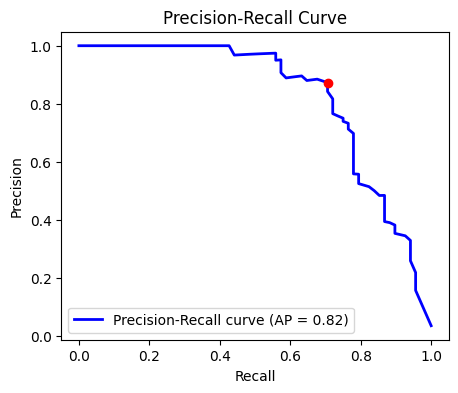

Best threshold for Precision-Recall curve: 0.45


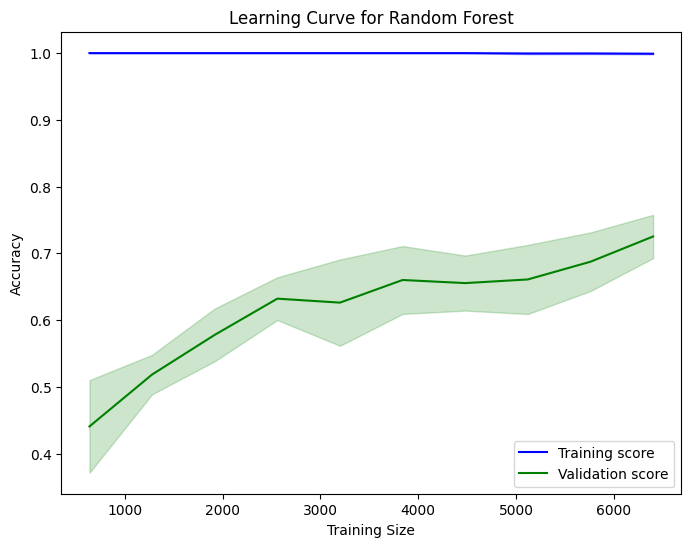

In [ ]:
# Initialize Random Forest without hyperparameter tuning
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("\n🔹 Random Forest (Without Grid Search)")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


# Get predicted probabilities
y_probs = rf_model.predict_proba(X_test)[:, 1]  # For binary classification, take probabilities for class 1

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)

# Compute the Average Precision score
avg_precision = average_precision_score(y_test, y_probs)

# Plot both ROC and Precision-Recall curves
fig, ax = plt.subplots(1, 1, figsize=(5, 4))


# Plot Precision-Recall curve
ax.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc='lower left')

# Choose the best threshold based on the curves:
# For ROC: Select the threshold that maximizes TPR and minimizes FPR (the "elbow" point).
best_roc_threshold = roc_thresholds[np.argmax(tpr - fpr)]  # Example heuristic

# For Precision-Recall: Choose the threshold that balances precision and recall, or maximizes F1-score.
f1_scores = 2 * (precision * recall) / (precision + recall)
best_pr_threshold = pr_thresholds[np.argmax(f1_scores)]  # Example heuristic

# Mark the best threshold based on recall
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red', label=f'Best Threshold (Recall) = {best_pr_threshold:.2f}', zorder=5)

plt.show()

print(f"Best threshold for Precision-Recall curve: {best_pr_threshold}")


# --- Add Learning Curve Plot ---
from sklearn.model_selection import StratifiedKFold, learning_curve

skf = StratifiedKFold(n_splits=5)
train_sizes, train_scores, val_scores = learning_curve(
    rf_model, X_train, y_train, cv=skf, scoring="f1", n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and std for train and validation scores
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, val_mean, label="Validation score", color="green")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2)
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# ✅ Define Hyperparameter Grid
param_grid = {
    "n_estimators": [200],
    "max_depth": [5,  None],
    "min_samples_split": [2, 5, 10]
}

# Grid Search for Best Parameters
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, class_weight="balanced"),
                              param_grid, cv=5, scoring="balanced_accuracy", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Train and Evaluate Best Model
best_rf_model = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

print("\n Best Random Forest Model (With Grid Search)")
print(classification_report(y_test, y_pred_best_rf))
print(confusion_matrix(y_test, y_pred_best_rf))


 Best Random Forest Model (With Grid Search)
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1932
           1       0.30      0.91      0.46        68

    accuracy                           0.93      2000
   macro avg       0.65      0.92      0.71      2000
weighted avg       0.97      0.93      0.94      2000

[[1790  142]
 [   6   62]]


In [ ]:
from sklearn.svm import SVC

# Initialize SVM with class weighting to handle imbalance
svm_model = SVC(kernel="rbf", class_weight="balanced", random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("\n Support Vector Machine (SVM)")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))



 Support Vector Machine (SVM)
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1932
           1       0.13      0.88      0.23        68

    accuracy                           0.79      2000
   macro avg       0.56      0.84      0.55      2000
weighted avg       0.97      0.79      0.86      2000

[[1527  405]
 [   8   60]]


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression with class weighting
log_reg_model = LogisticRegression(random_state=42, class_weight="balanced", max_iter=1000)

# Train the model
log_reg_model.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model
print("\n Logistic Regression")
print(classification_report(y_test, y_pred_log_reg))
print(confusion_matrix(y_test, y_pred_log_reg))



 Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1932
           1       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000

[[1594  338]
 [  12   56]]


In [ ]:
from xgboost import XGBClassifier

# ✅ Initialize XGBoost with scale_pos_weight to handle imbalance
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train) / y_train.sum(), use_label_encoder=False, eval_metric="logloss")

# ✅ Train the model
xgb_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# ✅ Evaluate the model
print("\n🔹 XGBoost Classifier")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:45:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.75      0.71        68

    accuracy                           0.98      2000
   macro avg       0.84      0.87      0.85      2000
weighted avg       0.98      0.98      0.98      2000

[[1908   24]
 [  17   51]]


In [ ]:
from lightgbm import LGBMClassifier

# Initialize LightGBM with balanced class weight
lgbm_model = LGBMClassifier(random_state=42, class_weight="balanced")

# Train the model
lgbm_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# ✅ Evaluate the model
print("\n🔹 LightGBM Classifier")
print(classification_report(y_test, y_pred_lgbm))
print(confusion_matrix(y_test, y_pred_lgbm))


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 264, number of negative: 7729
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

🔹 LightGBM Classifier
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.66      0.78      0.72        68

    accuracy                           0.98      2000
   macro avg       0.83      0.88      0.85      2000
weighted avg       0.98      0.98      0.98      2000

[[1905   27]
 [  15   53]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# ✅ Make predictions
y_pred_gb = gb_model.predict(X_test)

# ✅ Evaluate the model
print("\n🔹 Gradient Boosting Classifier")
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test, y_pred_gb))



🔹 Gradient Boosting Classifier
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1932
           1       0.86      0.63      0.73        68

    accuracy                           0.98      2000
   macro avg       0.92      0.81      0.86      2000
weighted avg       0.98      0.98      0.98      2000

[[1925    7]
 [  25   43]]


##Machine Learning algorithms with oversampling and scaling

In [ ]:
# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from xgboost import XGBClassifier

# ✅ Initialize XGBoost with scale_pos_weight to handle imbalance
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train) / y_train.sum(), use_label_encoder=False, eval_metric="logloss")

# ✅ Train the model
xgb_model.fit(X_train_scaled, y_train_resampled)

# ✅ Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# ✅ Evaluate the model
print("\n🔹 XGBoost Classifier")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:43:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classifier
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.38      0.84      0.52        68

    accuracy                           0.95      2000
   macro avg       0.69      0.89      0.75      2000
weighted avg       0.97      0.95      0.96      2000

[[1838   94]
 [  11   57]]


What You Can Do Next:
- Try different resampling techniques (e.g., RandomOverSampler, ADASYN instead of SMOTE).
- Test other classifiers like Support Vector Machines (SVM) or LightGBM.
- Use Stratified K-Fold Cross Validation to improve model selection.
- Evaluate models using ROC-AUC and Precision-Recall Curves.
Precision-Recall Curve
The Precision-Recall curve is especially useful when you have imbalanced classes. It shows the trade-off between precision and recall for different thresholds, highlighting the ability of the model to identify positive class instances.